# Goal of the ML project 
    - Predict if the user that add the product to cart will buy or not

## Steps in Pre processing
- Goal:
    -  - Predict if the user that add the product to cart will buy or not
Steps:
- Filter the dataset to only have rows for each first add_to_Cart_inside a session
- For each row, each first time a product_ was added to cart in a session, create olumn saying if the product was bought or not in that session (is_purchase)
- in another table, For every session, get
    - the total number of hits in a session (total_Activity)
    -  the total number of hits before the first add to cart (activity_before_add_to_Cart)
    - the total number of hits after the first add to cart (activity_after_add_to_Cart)
- merge the add_to_cart table with activity table by session_id and we have our dataset ready

Target:
- Is_purchase:
    - 0 : not purchase, after add to cart
    - 1 : purchase, after add to cart

# Import libraries

In [3]:
import pandas as pd
import numpy as np

# Import Functions

In [4]:
%run "dslabs_functions.py" #run notebook with functions made py the professor and that are going to be use in the project

dslabs_functions lodaded


In [95]:
#filepath=r'dataset/2020-Apr.csv'
#file_tag = 'dataset/2020-Apr.csv'


filepath=r'dataset/2019-Nov.csv'
file_tag = 'dataset/2019-Nov.csv'

# Load File

### >> method 1.1 - random sample with undersample of the negative class (remove 30000 rows) [BEING USED]

In [96]:
import pandas as pd

# Define a flag for test data
test_data = True  # Altere para False se quiser carregar todo o dataset

# Load the data
if test_data:
    df = pd.read_csv(filepath, na_values="")
    df = df.sample(frac=0.4, replace=False)
else:
    df = pd.read_csv(filepath, parse_dates=['event_time'])

# Exibir a contagem de classes antes do undersampling
print("Distribuição original:")
print(df['event_type'].value_counts(normalize=True))

# Separar as classes
df_not_purchase = df[df['event_type'] != 'purchase']
df_purchase = df[df['event_type'] == 'purchase']

# Verificar quantas linhas há na classe not_purchase
num_not_purchase = len(df_not_purchase)

# Definir o número de linhas a serem removidas
rows_to_remove = 0

# Verificar se há linhas suficientes para remover
if num_not_purchase > rows_to_remove:
    # Remover 30.000 linhas da classe not_purchase
    df_not_purchase_downsampled = df_not_purchase.sample(n=num_not_purchase - rows_to_remove, random_state=42)
else:
    print(f"A classe 'not_purchase' só contém {num_not_purchase} linhas. Usando todas as linhas.")
    df_not_purchase_downsampled = df_not_purchase.copy()  # Manter todas as linhas

# Combinar a classe downsampled com a classe purchase
df_balanced = pd.concat([df_not_purchase_downsampled, df_purchase])

# Embaralhar o dataset combinado
df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)



## Exibir a nova distribuição de classes
#print("Distribuição após undersampling:")
#print(df['event_type'].value_counts(normalize=True))

# Exibir as primeiras 20 linhas do dataset equilibrado
print(df.head(20))
df.info

Distribuição original:
event_type
view        0.941518
cart        0.044902
purchase    0.013581
Name: proportion, dtype: float64
                 event_time event_type  product_id          category_id  \
0   2019-11-23 05:32:50 UTC       view     4804241  2053013554658804075   
1   2019-11-17 06:56:59 UTC       view     2900200  2053013554776244595   
2   2019-11-14 18:19:22 UTC       view     1307520  2053013558920217191   
3   2019-11-07 14:00:10 UTC       view     1004104  2053013555631882655   
4   2019-11-24 06:26:45 UTC       view     6201023  2053013552293216471   
5   2019-11-26 06:23:19 UTC       view    22700208  2053013556168753601   
6   2019-11-17 13:45:35 UTC       view    41100001  2090228413959766319   
7   2019-11-22 10:07:33 UTC       view     2702666  2053013563911439225   
8   2019-11-05 16:47:29 UTC       view    57000018  2152289064542273825   
9   2019-11-14 14:34:10 UTC       view     2601594  2053013563970159485   
10  2019-11-15 12:30:05 UTC       cart     10

<bound method DataFrame.info of                        event_time event_type  product_id          category_id  \
0         2019-11-23 05:32:50 UTC       view     4804241  2053013554658804075   
1         2019-11-17 06:56:59 UTC       view     2900200  2053013554776244595   
2         2019-11-14 18:19:22 UTC       view     1307520  2053013558920217191   
3         2019-11-07 14:00:10 UTC       view     1004104  2053013555631882655   
4         2019-11-24 06:26:45 UTC       view     6201023  2053013552293216471   
...                           ...        ...         ...                  ...   
27000787  2019-11-15 19:40:54 UTC       view     1005117  2053013555631882655   
27000788  2019-11-25 05:35:56 UTC   purchase    25509900  2053013562208551707   
27000789  2019-11-26 14:34:39 UTC       view    10502145  2053013553199186187   
27000790  2019-11-17 11:14:52 UTC       view    29000001  2053013562871251777   
27000791  2019-11-25 13:41:35 UTC       cart   100017829  2053013561218695907

# Get to know the data

In [215]:
df.shape


AttributeError: 'tuple' object has no attribute 'shape'

In [216]:
df.head()

AttributeError: 'tuple' object has no attribute 'head'

## How many visitors visited the site?

### How many visitors visited the site - total

In [136]:
visitor = df["user_id"].nunique()
print("Number of visitors",visitor)


Number of visitors 2965558


### How many visitors visited the site - Over time

In [137]:
#get only day from event_time
df["event_time_day"] = df["event_time"].apply(lambda s: str(s)[0:10])

df_visitors_time = df.loc[:,["event_time_day","user_id"]]
df_visitors_time.head()

,event_time_day,user_id
0,2019-11-26,527555955
1,2019-11-26,549393003
2,2019-11-24,554834573
3,2019-11-17,547157009
4,2019-11-16,556826605


In [138]:
visitor_by_date = df.drop_duplicates().groupby(['event_time_day'])['user_id'].agg(['count']).sort_values(by=['event_time_day'], ascending=True)

visitor_by_date.head()

,count
event_time_day,
2019-11-01,578313
2019-11-02,623441
2019-11-03,626586
2019-11-04,717165
2019-11-05,686031


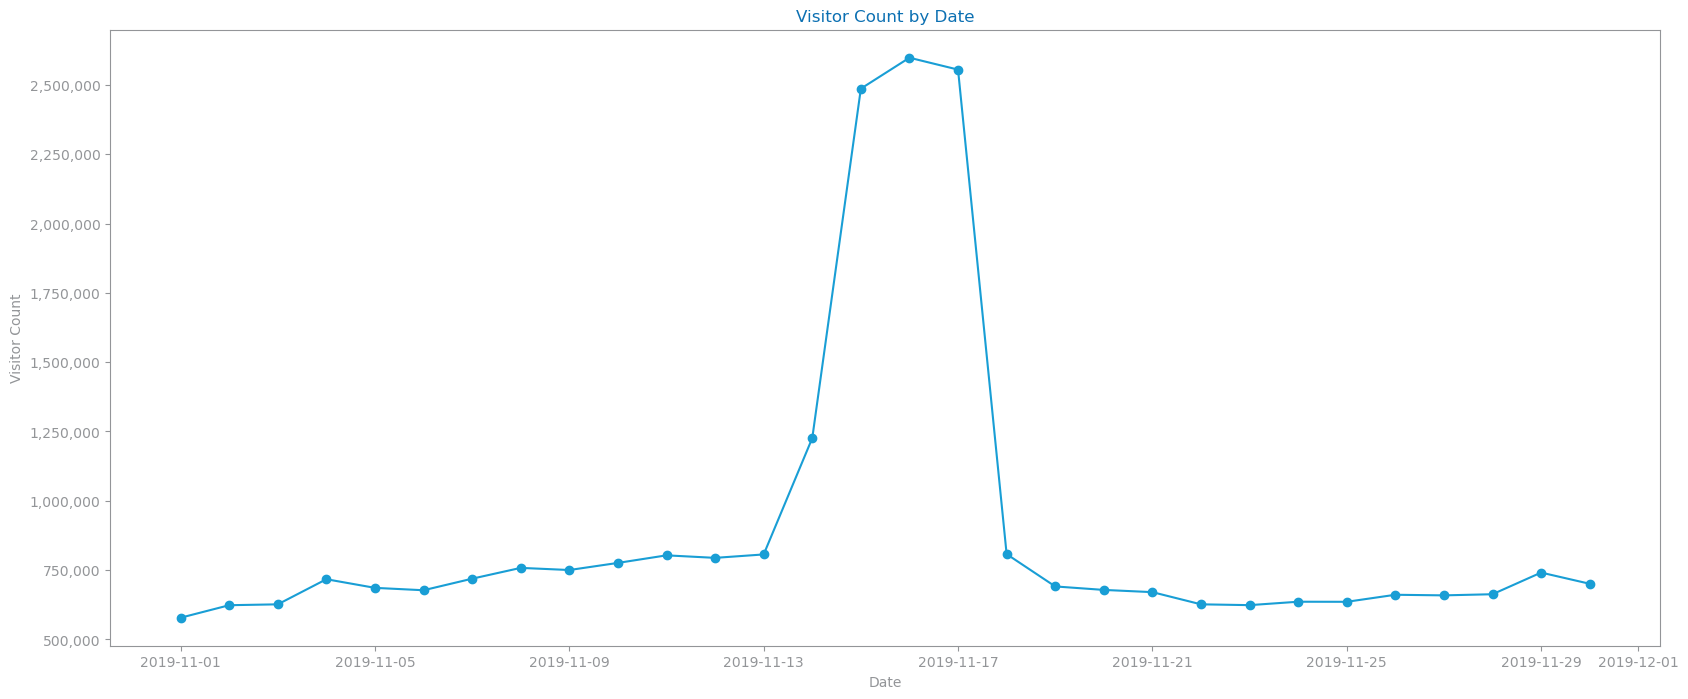

In [139]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime  # Importing datetime for date manipulation
import matplotlib.ticker as ticker


# Assuming visitor_by_date has already been defined
x = pd.Series(visitor_by_date.index.values).apply(lambda s: datetime.strptime(s, '%Y-%m-%d').date())
y = visitor_by_date['count']

# Setting the figure size
plt.figure(figsize=(20, 8))

# Creating the plot
plt.plot(x, y, marker='o')  # Adding markers to each data point

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Visitor Count')
plt.title('Visitor Count by Date')

# Setting the y-axis format to show integer values
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Displaying the plot
plt.show()



In [27]:
print(visitor_by_date)
print(visitor_by_date.dtypes)
print(y.head())


              count
event_time         
2019-11-01   375063
2019-11-02   403623
2019-11-03   405872
2019-11-04   466555
2019-11-05   447222
2019-11-06   439987
2019-11-07   468353
2019-11-08   494595
2019-11-09   487199
2019-11-10   504388
2019-11-11   524436
2019-11-12   518289
2019-11-13   525778
2019-11-14   778338
2019-11-15  1542748
2019-11-16  1654666
2019-11-17  1623440
2019-11-18   530124
2019-11-19   451956
2019-11-20   444028
2019-11-21   437968
2019-11-22   408466
2019-11-23   405454
2019-11-24   412738
2019-11-25   415868
2019-11-26   431024
2019-11-27   430007
2019-11-28   432513
2019-11-29   480766
2019-11-30   452659
count    int64
dtype: object
event_time
2019-11-01    375063
2019-11-02    403623
2019-11-03    405872
2019-11-04    466555
2019-11-05    447222
Name: count, dtype: int64


### Insigths
- It is clear that we have three times more users during the period from November 13 to November 18 compared to the other days in the dataset. Given the dates, this likely corresponds to a Black Friday period or promotions that attracted many visitors to the website.

-It is also clear that time variables, such as weekday and week of the month, will likely be very important for predicting our target variable.

## Which category customers interact the most? What brand the view to most?



In [142]:
top_category_n = 20

top_category = df.loc[:,"category_code"].value_counts()[:top_category_n].sort_values(ascending=False)
top_category.head(20)

category_code
electronics.smartphone              6549867
electronics.video.tv                 883537
computers.notebook                   871747
electronics.clocks                   835650
apparel.shoes                        754434
electronics.audio.headphone          725816
appliances.environment.vacuum        612121
appliances.kitchen.refrigerators     569859
appliances.kitchen.washer            562656
computers.desktop                    275796
furniture.living_room.cabinet        220192
furniture.bedroom.bed                212815
electronics.tablet                   197416
apparel.shoes.keds                   194007
auto.accessories.player              189146
furniture.living_room.sofa           169784
construction.tools.drill             159312
appliances.kitchen.oven              151841
kids.carriage                        139235
electronics.telephone                138683
Name: count, dtype: int64

In [143]:
import pandas as pd
import plotly.express as px

# Assuming top_category is already defined, e.g.:
# top_category = pd.Series([10, 20, 30, 40], index=['Category A', 'Category B', 'Category C', 'Category D'])
# Convert top_category to a DataFrame for Plotly
top_category_df = top_category.reset_index()
top_category_df.columns = ['Category', 'Value']  # Renaming columns

# Creating the treemap
fig = px.treemap(top_category_df, 
                 path=['Category'], 
                 values='Value',
                 color='Value',
                 color_continuous_scale=['red', 'cyan', 'green', 'orange', 'blue', 'grey'],
                 title='Treemap of Top Categories')

# Show the plot
fig.show()


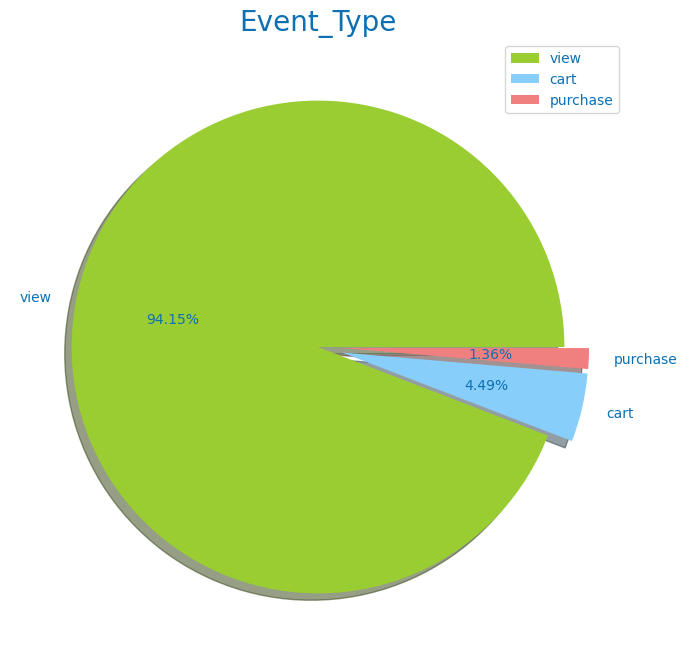

In [144]:
labels = ['view', 'cart','purchase']
size = df['event_type'].value_counts()
colors = ['yellowgreen', 'lightskyblue','lightcoral']
explode = [0, 0.1,0.1]

plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Event_Type', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

## Which Brand and category customers are buyng the most? 

### Which product_ids are they buying the most?

In [145]:
purchase = df.loc[df['event_type'] == 'purchase']
purchase = purchase.dropna(axis='rows')
purchase.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_time_day
96,2019-11-05 08:34:33 UTC,purchase,1005177,2053013555631882655,electronics.smartphone,samsung,900.64,512487885,37fc7d84-e078-4d8f-af05-79a851fbeb9a,2019-11-05
105,2019-11-29 03:05:35 UTC,purchase,5100715,2053013553341792533,electronics.clocks,aimoto,53.54,567404193,25f94a15-98ce-4951-9f77-db8fae02733e,2019-11-29
348,2019-11-30 03:57:04 UTC,purchase,1004767,2053013555631882655,electronics.smartphone,samsung,242.70,547313357,76cf5046-6606-43b0-b7e5-c5f3b78f6127,2019-11-30
554,2019-11-17 16:40:43 UTC,purchase,1307096,2053013558920217191,computers.notebook,lenovo,369.64,544843388,bb9a9165-1527-4711-a3d8-0714be507e5c,2019-11-17
935,2019-11-07 16:21:58 UTC,purchase,8801085,2053013555573162395,electronics.telephone,nokia,21.85,564337503,e0122e7f-59c9-4625-861d-99a8c0617ad6,2019-11-07


### Which category_ids are they buying the most?

In [146]:
import pandas as pd

# Assuming df is your DataFrame and it contains the necessary columns
# Filter the DataFrame for purchased items
purchased_items = df[df['event_type'] == "purchase"]

# Count the occurrences of each product_id and get the top 5
top_10_products = purchased_items['product_id'].value_counts().head(10)

top_10_products.head(10)


product_id
1004856    12897
1004767     9009
1005115     8989
4804056     7076
1004833     5448
1002544     4694
1004870     4301
1005100     4113
1004249     3655
1005105     3382
Name: count, dtype: int64

In [147]:
import pandas as pd

# Assuming df is your DataFrame and it contains the necessary columns
# Filter the DataFrame for purchased items
purchased_items = df[df['event_type'] == "purchase"]

# Count the occurrences of each product_id and get the top 5
top_10_products = purchased_items['category_code'].value_counts().head(10)

top_10_products.head(10)

category_code
electronics.smartphone              153359
electronics.audio.headphone          16153
electronics.video.tv                 12054
electronics.clocks                    9313
appliances.kitchen.washer             8022
computers.notebook                    7473
appliances.environment.vacuum         7284
appliances.kitchen.refrigerators      5156
apparel.shoes                         4036
electronics.tablet                    2412
Name: count, dtype: int64

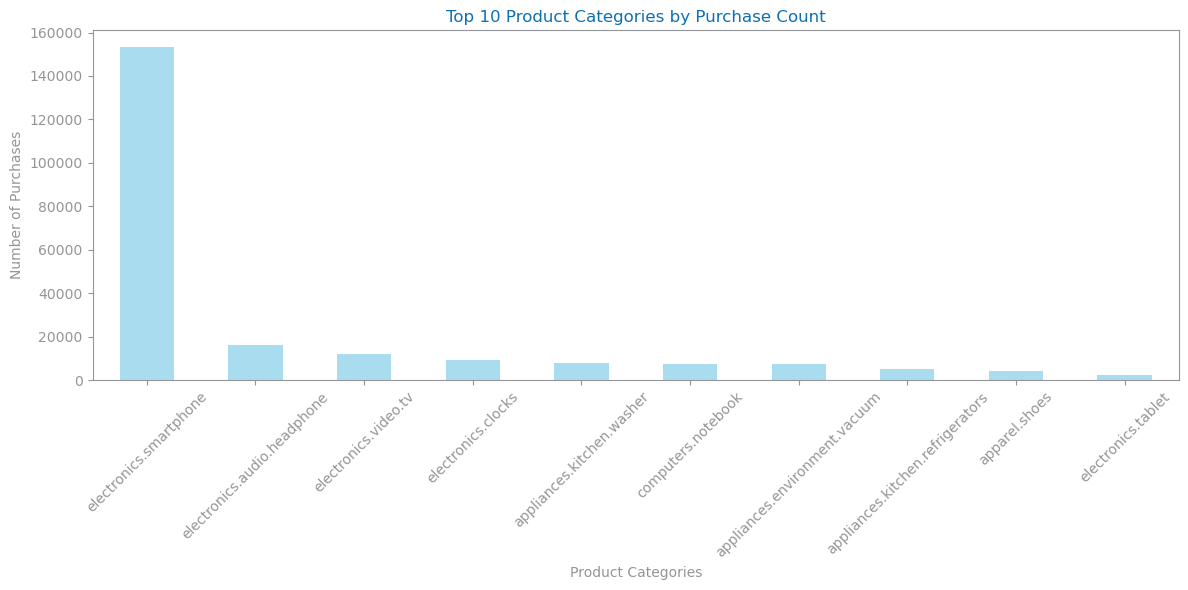

In [148]:
# Plotting
plt.figure(figsize=(12, 6))  # Set the figure size
top_10_products.plot(kind='bar', color='skyblue', alpha=0.7)  # Create a bar chart

# Adding titles and labels
plt.title('Top 10 Product Categories by Purchase Count')
plt.xlabel('Product Categories')
plt.ylabel('Number of Purchases')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

#### Insights
- Clearly smarphones are the type of products most bought in this period in the store. 10x times the second category in the list

### Which brands are they buying the most?

In [149]:
top_sellers = purchase.groupby('brand')['brand'].agg(['count']).sort_values('count', ascending=False)
top_sellers.head(20)


,count
brand,
samsung,79668
apple,66272
xiaomi,23178
huawei,9366
oppo,5983
lg,4729
artel,2904
lenovo,2677
acer,2648


#### Insights
- Since smartphones are by far the most purchased product category, it also makes sense that the most purchased brands are Samsung and Apple

# Save initial dataset from pre_processing before cleaning

In [97]:

# Definir o caminho para salvar o arquivo CSV
filepath = r'dataset/df_ecom_initial_dataset.csv'

# Salvar o DataFrame em CSV
df.to_csv(filepath, index=False)

In [6]:
filepath_init=r'dataset/df_ecom_initial_dataset.csv'

### Load file without always creating a new random sample

In [7]:
test_data = False
# test_data = False

# Load the data
if test_data:
    df_init = pd.read_csv(filepath_init, na_values="")

    df_init: DataFrame = df.sample(frac=0.0015, replace = False)

else:
    # If not test_data, load the entire dataset
    df_init = pd.read_csv(filepath_init)

# Display the first 100 rows of the DataFrame


df_init.head(10)


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-23 05:32:50 UTC,view,4804241,2053013554658804075,electronics.audio.headphone,defender,10.48,514690964,0961faa8-c447-4913-a25a-9441217f5b22
1,2019-11-17 06:56:59 UTC,view,2900200,2053013554776244595,appliances.kitchen.microwave,lg,90.07,542774311,f13dad8c-724c-4ac5-81e8-964475b5738a
2,2019-11-14 18:19:22 UTC,view,1307520,2053013558920217191,computers.notebook,lenovo,849.42,516348595,ec062062-41de-44f9-a553-dd09ebed9c22
3,2019-11-07 14:00:10 UTC,view,1004104,2053013555631882655,electronics.smartphone,bq,174.53,547470854,a52b5449-372b-4ad2-9094-e85e4687a04e
4,2019-11-24 06:26:45 UTC,view,6201023,2053013552293216471,appliances.environment.air_heater,NaN,72.82,518089649,c7b32ada-c7b7-44af-83f0-f42bba37384e
5,2019-11-26 06:23:19 UTC,view,22700208,2053013556168753601,NaN,stels,77.22,572833601,857f3357-7161-4f46-8aa1-ac3dfbd2fd10
6,2019-11-17 13:45:35 UTC,view,41100001,2090228413959766319,NaN,NaN,77.99,562695757,ae24b386-58d5-4428-baca-c1e5dea82953
7,2019-11-22 10:07:33 UTC,view,2702666,2053013563911439225,appliances.kitchen.refrigerators,indesit,293.42,515624123,83750dd1-f2d6-4022-beb0-1d9b7e3ed6a1
8,2019-11-05 16:47:29 UTC,view,57000018,2152289064542273825,NaN,alteco,46.33,515775827,8f400b13-6279-4e20-9240-9bd4c9bac92c
9,2019-11-14 14:34:10 UTC,view,2601594,2053013563970159485,NaN,shivaki,183.98,515610113,24639c6c-74e7-4bff-bf8c-ecc89252dd53


# Tranform our Dataset
- FEature enginenering steps:
    - Filter the dataset to only have rows for each first add_to_Cart_inside a session
    - For each row, each first time a product_ was added to cart in a session, create olumn saying if the product was bought or not in that session (is_purchase)
    
    - in another table, For every session, get
        - the total number of hits in a session (total_Activity)
        -  the total number of hits before the first add to cart (activity_before_add_to_Cart)
        - the total number of hits after the first add to cart (activity_after_add_to_Cart)
    - merge the add_to_cart table with activity table by session_id and we have our dataset ready

Add columns:
- Split category_code into:
    - category_code_lvl_1
    - category_code_lvl_3
    - create time columns for event_time:
        - weekday
        - time_of_day
        - week_of_month
        - is_weekend
        - day


Target:
- Is_purchase:
    - 0 : not purchase, after add to cart
    - 1 : purchase, after add to cart

## Filter dataset to only have add_to_Cart data

In [135]:
import pandas as pd
import numpy as np
from datetime import datetime

#1 - filter for rows only with event type add_to_cart or purchase 
#2 - drop duplicate, to only have the first ocurrence for each product_id inside each session_id

#By using .drop_duplicates(subset=['event_type', 'product_id', 'user_id', 'session_id']), we are ensuring that you keep only the first occurrence of each combination of event_type, product_id, user_id, and session_id.

df_cart = df_init.loc[df_init["event_type"].isin(["cart", "purchase"])].drop_duplicates(subset=['event_type', 'product_id', 'user_id', 'user_session'])

df_cart.head()


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
10,2019-11-15 12:30:05 UTC,cart,1005159,2053013555631882655,electronics.smartphone,xiaomi,202.50,542945060,aec88722-d9f6-4c09-9b98-7e499f5cd216
19,2019-11-16 12:06:52 UTC,cart,15700019,2053013559733912211,NaN,NaN,334.37,512405533,c9a9eaab-da98-4950-aa54-dfc7bc64741c
44,2019-11-29 04:01:19 UTC,cart,1004227,2053013555631882655,electronics.smartphone,apple,952.15,540780636,c83e85db-9c3e-4b83-a589-d22ece3688d6
53,2019-11-10 00:30:18 UTC,purchase,1005115,2053013555631882655,electronics.smartphone,apple,914.64,567265963,acb1eb81-9ecc-475d-828c-0c74286503e1
67,2019-11-16 16:53:41 UTC,cart,3601250,2053013563810775923,appliances.kitchen.washer,samsung,347.47,514494468,23da1a95-8d92-45b1-9421-a3eaf022c954


In [55]:
df_cart.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1339790 entries, 10 to 27000791
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   event_time     1339790 non-null  object 
 1   event_type     1339790 non-null  object 
 2   product_id     1339790 non-null  int64  
 3   category_id    1339790 non-null  int64  
 4   category_code  973608 non-null   object 
 5   brand          1224281 non-null  object 
 6   price          1339790 non-null  float64
 7   user_id        1339790 non-null  int64  
 8   user_session   1339784 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 102.2+ MB


### Removing few rows with user_session null, because we can't use them in our model

In [136]:
df_cart = df_cart.dropna(subset=['user_session'])

In [13]:
df_cart.shape

(1339784, 9)

### Creating target value

In [137]:
df_cart['is_purchase'] = 0  # Definindo valor padrão
df_cart.loc[df_cart['event_type']=='purchase', 'is_purchase'] = 1

df_cart.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchase
10,2019-11-15 12:30:05 UTC,cart,1005159,2053013555631882655,electronics.smartphone,xiaomi,202.50,542945060,aec88722-d9f6-4c09-9b98-7e499f5cd216,0
19,2019-11-16 12:06:52 UTC,cart,15700019,2053013559733912211,NaN,NaN,334.37,512405533,c9a9eaab-da98-4950-aa54-dfc7bc64741c,0
44,2019-11-29 04:01:19 UTC,cart,1004227,2053013555631882655,electronics.smartphone,apple,952.15,540780636,c83e85db-9c3e-4b83-a589-d22ece3688d6,0
53,2019-11-10 00:30:18 UTC,purchase,1005115,2053013555631882655,electronics.smartphone,apple,914.64,567265963,acb1eb81-9ecc-475d-828c-0c74286503e1,1
67,2019-11-16 16:53:41 UTC,cart,3601250,2053013563810775923,appliances.kitchen.washer,samsung,347.47,514494468,23da1a95-8d92-45b1-9421-a3eaf022c954,0


### Filter cart and purchase data

In [138]:
#for each session and product_id, if it 1 hit with is_purchase=1, fill 1 for all rows for that product and session
df_cart["is_purchase"] = df_cart.groupby(["user_session", "product_id"])["is_purchase"].transform("max")


df_cart.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchase
10,2019-11-15 12:30:05 UTC,cart,1005159,2053013555631882655,electronics.smartphone,xiaomi,202.50,542945060,aec88722-d9f6-4c09-9b98-7e499f5cd216,0
19,2019-11-16 12:06:52 UTC,cart,15700019,2053013559733912211,NaN,NaN,334.37,512405533,c9a9eaab-da98-4950-aa54-dfc7bc64741c,0
44,2019-11-29 04:01:19 UTC,cart,1004227,2053013555631882655,electronics.smartphone,apple,952.15,540780636,c83e85db-9c3e-4b83-a589-d22ece3688d6,1
53,2019-11-10 00:30:18 UTC,purchase,1005115,2053013555631882655,electronics.smartphone,apple,914.64,567265963,acb1eb81-9ecc-475d-828c-0c74286503e1,1
67,2019-11-16 16:53:41 UTC,cart,3601250,2053013563810775923,appliances.kitchen.washer,samsung,347.47,514494468,23da1a95-8d92-45b1-9421-a3eaf022c954,0


In [18]:
# Assuming df is your original DataFrame
duplicate_sessions = df_cart[df_cart.duplicated(subset='user_session', keep=False)]

# Display the duplicate rows
duplicate_sessions.head(10)


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchase
44,2019-11-29 04:01:19 UTC,cart,1004227,2053013555631882655,electronics.smartphone,apple,952.15,540780636,c83e85db-9c3e-4b83-a589-d22ece3688d6,1
53,2019-11-10 00:30:18 UTC,purchase,1005115,2053013555631882655,electronics.smartphone,apple,914.64,567265963,acb1eb81-9ecc-475d-828c-0c74286503e1,1
105,2019-11-21 07:41:30 UTC,purchase,100013980,2053013555631882655,electronics.smartphone,xiaomi,231.67,573178239,05ac207d-2c90-47cb-a40f-639d1a352963,1
522,2019-11-08 04:58:08 UTC,cart,1004749,2053013555631882655,electronics.smartphone,samsung,195.08,561758421,0f25ff27-f2cc-409d-bdb6-ea57a8cf11df,0
573,2019-11-17 10:53:50 UTC,cart,3701056,2053013565983425517,appliances.environment.vacuum,samsung,69.47,512933969,48308cf2-3b9e-4edf-8c0d-53afc9e081ff,0
602,2019-11-13 07:23:28 UTC,cart,27700710,2053013560086233771,construction.tools.pump,NaN,105.51,513137635,c6ba0097-7377-48fd-bc5f-c98f58946907,0
637,2019-11-15 09:23:54 UTC,cart,12500153,2053013556277805513,NaN,dwt,30.61,548875301,616c4c55-9b5c-43bb-8d68-d6f8e1ea2a8b,0
790,2019-11-09 13:51:57 UTC,cart,11400383,2053013558458843721,NaN,takeit,17.99,523075671,adec572f-fc05-4403-abf9-84b3332b8892,0
838,2019-11-15 16:39:07 UTC,cart,1005115,2053013555631882655,electronics.smartphone,apple,914.00,524061395,e81aab37-3cf5-4e7d-85fa-02729cb3fa73,0
934,2019-11-13 07:26:23 UTC,cart,26601447,2053013563517174627,NaN,NaN,84.17,518615228,c9452e95-24e8-4a21-8a6e-722c109b45b8,1


In [19]:
user_session = "86a590db-bde4-4385-963f-51c532c5cb8f"
user_session = df_cart[df_cart["user_session"] == user_session]

user_session.head(50)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchase
15714119,2019-11-18 05:16:30 UTC,purchase,1005100,2053013555631882655,electronics.smartphone,samsung,136.14,546551898,86a590db-bde4-4385-963f-51c532c5cb8f,1
20068104,2019-11-18 04:07:18 UTC,cart,35600001,2070747673266226092,NaN,NaN,16.40,546551898,86a590db-bde4-4385-963f-51c532c5cb8f,0


In [24]:
user_session = "05ac207d-2c90-47cb-a40f-639d1a352963"
user_session = df_cart[df_cart["user_session"] == user_session]

user_session.head(50)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchase
16451758,2019-11-21 07:38:10 UTC,cart,100013980,2053013555631882655,electronics.smartphone,xiaomi,231.67,573178239,05ac207d-2c90-47cb-a40f-639d1a352963,1


In [139]:
#filter for the dataset to exclude the rows with event_type=purchase, becasue we already created the target column is_purchase and now we only want the rows with add_to_Cart
df_cart = df_cart.loc[df_cart["event_type"] == "cart"].drop_duplicates(["user_session", "product_id", "is_purchase"])


In [107]:
df_cart.shape

(984013, 10)

In [22]:
user_session = "37daf8e9-57b8-4d69-9acc-811ba74cbf61"
user_session = df_cart[df_cart["user_session"] == user_session]

user_session.head(50)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchase
5850742,2019-11-17 13:28:26 UTC,cart,1801690,2053013554415534427,electronics.video.tv,samsung,406.45,572088450,37daf8e9-57b8-4d69-9acc-811ba74cbf61,0


In [23]:
user_session = "86a590db-bde4-4385-963f-51c532c5cb8f"
user_session = df_cart[df_cart["user_session"] == user_session]

user_session.head(50)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchase
20068104,2019-11-18 04:07:18 UTC,cart,35600001,2070747673266226092,NaN,NaN,16.4,546551898,86a590db-bde4-4385-963f-51c532c5cb8f,0


is_purchase
0    836473
1    147540
Name: count, dtype: int64


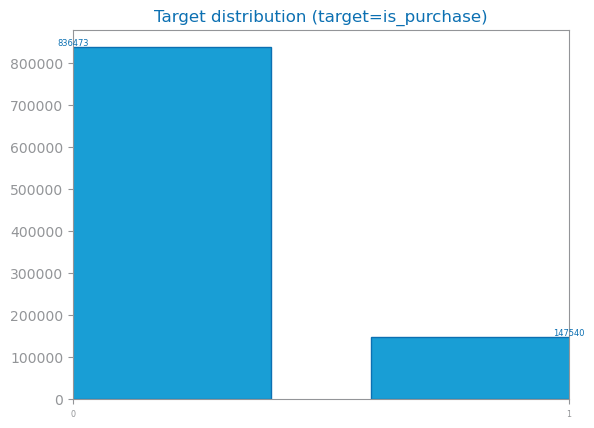

In [140]:
from matplotlib.pyplot import savefig, show
target = "is_purchase"

values: Series = df_cart[target].value_counts()
print(values)

Figure(figsize=(4, 2))
plot_bar_chart(
    values.index.to_list(),
    values.to_list(),
    title=f"Target distribution (target={target})",
)
#savefig(f"images/{file_tag}_class_distribution.png")
show()

In [141]:
# Verificar se 'event_time' está presente e é do tipo datetime
if 'event_time' in df_cart.columns and pd.api.types.is_datetime64_any_dtype(df_cart['event_time']):
    # Conta o número de dias únicos
    num_unique_days = df_cart['event_time'].nunique()
    print(f"Número de dias únicos: {num_unique_days}")
else:
    print("A coluna 'event_time' não existe ou não é do tipo datetime.")

# Contar valores distintos em todas as colunas
distinct_values = df_cart.nunique()
print("Número de valores distintos por coluna:")
print(distinct_values)

A coluna 'event_time' não existe ou não é do tipo datetime.
Número de valores distintos por coluna:
event_time       641037
event_type            1
product_id        60657
category_id         635
category_code       127
brand              2731
price             24884
user_id          542059
user_session     899892
is_purchase           2
dtype: int64


In [27]:
df_cart.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchase
10,2019-11-15 12:30:05 UTC,cart,1005159,2053013555631882655,electronics.smartphone,xiaomi,202.50,542945060,aec88722-d9f6-4c09-9b98-7e499f5cd216,0
19,2019-11-16 12:06:52 UTC,cart,15700019,2053013559733912211,NaN,NaN,334.37,512405533,c9a9eaab-da98-4950-aa54-dfc7bc64741c,0
44,2019-11-29 04:01:19 UTC,cart,1004227,2053013555631882655,electronics.smartphone,apple,952.15,540780636,c83e85db-9c3e-4b83-a589-d22ece3688d6,1
67,2019-11-16 16:53:41 UTC,cart,3601250,2053013563810775923,appliances.kitchen.washer,samsung,347.47,514494468,23da1a95-8d92-45b1-9421-a3eaf022c954,0
76,2019-11-17 13:13:52 UTC,cart,1005160,2053013555631882655,electronics.smartphone,xiaomi,202.06,570419542,262d0bf6-a153-4b2d-9e6b-a1863dfd0353,0


## Add new extracted columns based on dataset cols

#### Data granularity

##### Add split category_code column

In [142]:

# Create new columns based on the column category_based
df_cart['category_code_lvl_1'] = df_cart['category_code'].str.split(".").str[0] #Obter o 1º nivel do category code e criar nova coluna
df_cart['category_code_lvl_2'] = df_cart['category_code'].str.split(".").str[1] #Obter o 2º nivel do category code e criar nova coluna


df_cart.head(10)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchase,category_code_lvl_1,category_code_lvl_2
10,2019-11-15 12:30:05 UTC,cart,1005159,2053013555631882655,electronics.smartphone,xiaomi,202.50,542945060,aec88722-d9f6-4c09-9b98-7e499f5cd216,0,electronics,smartphone
19,2019-11-16 12:06:52 UTC,cart,15700019,2053013559733912211,NaN,NaN,334.37,512405533,c9a9eaab-da98-4950-aa54-dfc7bc64741c,0,NaN,NaN
44,2019-11-29 04:01:19 UTC,cart,1004227,2053013555631882655,electronics.smartphone,apple,952.15,540780636,c83e85db-9c3e-4b83-a589-d22ece3688d6,1,electronics,smartphone
67,2019-11-16 16:53:41 UTC,cart,3601250,2053013563810775923,appliances.kitchen.washer,samsung,347.47,514494468,23da1a95-8d92-45b1-9421-a3eaf022c954,0,appliances,kitchen
76,2019-11-17 13:13:52 UTC,cart,1005160,2053013555631882655,electronics.smartphone,xiaomi,202.06,570419542,262d0bf6-a153-4b2d-9e6b-a1863dfd0353,0,electronics,smartphone
94,2019-11-11 07:26:46 UTC,cart,1005217,2053013555631882655,electronics.smartphone,xiaomi,151.35,512424424,5db8494d-b4a1-4b44-acda-b30dc213dfce,0,electronics,smartphone
125,2019-11-17 12:28:22 UTC,cart,1002524,2053013555631882655,electronics.smartphone,apple,561.66,548513286,e9ed536d-a330-4b74-805d-08b8ee87b66c,0,electronics,smartphone
206,2019-11-15 17:47:57 UTC,cart,1004433,2053013555631882655,electronics.smartphone,samsung,334.37,529504153,ea76da02-467d-4804-9c63-6d632c9d9d67,0,electronics,smartphone
213,2019-11-20 10:42:06 UTC,cart,4804056,2053013554658804075,electronics.audio.headphone,apple,165.84,531262769,68bf31ca-fcf1-4405-a356-3d589f1bb2a8,0,electronics,audio
388,2019-11-16 08:28:11 UTC,cart,4300279,2053013552385491165,NaN,ballu,43.50,562336165,5a2c6f18-afe6-4f97-8c3a-ef2848ec874c,0,NaN,NaN


###### Convert category_code_level_2 and category_code_level_3 into funnel pages.
- fill ategory_code_level_3 with values from category_code_level_2

This is needed because some product categories don't have category_code_lvl

In [143]:
# Atualizar a coluna category_code_lvl_2_new, preservando os valores NaN
df_cart['category_code_lvl_2_new'] = df_cart['category_code_lvl_2'].where(df_cart['category_code_lvl_2'].isna(), df_cart['category_code_lvl_1'] + "/" + df_cart['category_code_lvl_2'])

# Verificar as primeiras linhas do DataFrame
df_cart.head(10)



,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchase,category_code_lvl_1,category_code_lvl_2,category_code_lvl_2_new
10,2019-11-15 12:30:05 UTC,cart,1005159,2053013555631882655,electronics.smartphone,xiaomi,202.50,542945060,aec88722-d9f6-4c09-9b98-7e499f5cd216,0,electronics,smartphone,electronics/smartphone
19,2019-11-16 12:06:52 UTC,cart,15700019,2053013559733912211,NaN,NaN,334.37,512405533,c9a9eaab-da98-4950-aa54-dfc7bc64741c,0,NaN,NaN,NaN
44,2019-11-29 04:01:19 UTC,cart,1004227,2053013555631882655,electronics.smartphone,apple,952.15,540780636,c83e85db-9c3e-4b83-a589-d22ece3688d6,1,electronics,smartphone,electronics/smartphone
67,2019-11-16 16:53:41 UTC,cart,3601250,2053013563810775923,appliances.kitchen.washer,samsung,347.47,514494468,23da1a95-8d92-45b1-9421-a3eaf022c954,0,appliances,kitchen,appliances/kitchen
76,2019-11-17 13:13:52 UTC,cart,1005160,2053013555631882655,electronics.smartphone,xiaomi,202.06,570419542,262d0bf6-a153-4b2d-9e6b-a1863dfd0353,0,electronics,smartphone,electronics/smartphone
94,2019-11-11 07:26:46 UTC,cart,1005217,2053013555631882655,electronics.smartphone,xiaomi,151.35,512424424,5db8494d-b4a1-4b44-acda-b30dc213dfce,0,electronics,smartphone,electronics/smartphone
125,2019-11-17 12:28:22 UTC,cart,1002524,2053013555631882655,electronics.smartphone,apple,561.66,548513286,e9ed536d-a330-4b74-805d-08b8ee87b66c,0,electronics,smartphone,electronics/smartphone
206,2019-11-15 17:47:57 UTC,cart,1004433,2053013555631882655,electronics.smartphone,samsung,334.37,529504153,ea76da02-467d-4804-9c63-6d632c9d9d67,0,electronics,smartphone,electronics/smartphone
213,2019-11-20 10:42:06 UTC,cart,4804056,2053013554658804075,electronics.audio.headphone,apple,165.84,531262769,68bf31ca-fcf1-4405-a356-3d589f1bb2a8,0,electronics,audio,electronics/audio
388,2019-11-16 08:28:11 UTC,cart,4300279,2053013552385491165,NaN,ballu,43.50,562336165,5a2c6f18-afe6-4f97-8c3a-ef2848ec874c,0,NaN,NaN,NaN


In [144]:
#drop columns
# Remover as colunas temporárias (category_code_lvl_2_new e category_code_lvl_3_new se não precisar mais delas)
df_cart.drop(columns=['category_code_lvl_2'], inplace=True)

df_cart.rename(columns={
    'category_code_lvl_2_new': 'category_code_lvl_2'
}, inplace=True)

# Verificar as primeiras linhas do DataFrame
df_cart.head(10)


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,is_purchase,category_code_lvl_1,category_code_lvl_2
10,2019-11-15 12:30:05 UTC,cart,1005159,2053013555631882655,electronics.smartphone,xiaomi,202.50,542945060,aec88722-d9f6-4c09-9b98-7e499f5cd216,0,electronics,electronics/smartphone
19,2019-11-16 12:06:52 UTC,cart,15700019,2053013559733912211,NaN,NaN,334.37,512405533,c9a9eaab-da98-4950-aa54-dfc7bc64741c,0,NaN,NaN
44,2019-11-29 04:01:19 UTC,cart,1004227,2053013555631882655,electronics.smartphone,apple,952.15,540780636,c83e85db-9c3e-4b83-a589-d22ece3688d6,1,electronics,electronics/smartphone
67,2019-11-16 16:53:41 UTC,cart,3601250,2053013563810775923,appliances.kitchen.washer,samsung,347.47,514494468,23da1a95-8d92-45b1-9421-a3eaf022c954,0,appliances,appliances/kitchen
76,2019-11-17 13:13:52 UTC,cart,1005160,2053013555631882655,electronics.smartphone,xiaomi,202.06,570419542,262d0bf6-a153-4b2d-9e6b-a1863dfd0353,0,electronics,electronics/smartphone
94,2019-11-11 07:26:46 UTC,cart,1005217,2053013555631882655,electronics.smartphone,xiaomi,151.35,512424424,5db8494d-b4a1-4b44-acda-b30dc213dfce,0,electronics,electronics/smartphone
125,2019-11-17 12:28:22 UTC,cart,1002524,2053013555631882655,electronics.smartphone,apple,561.66,548513286,e9ed536d-a330-4b74-805d-08b8ee87b66c,0,electronics,electronics/smartphone
206,2019-11-15 17:47:57 UTC,cart,1004433,2053013555631882655,electronics.smartphone,samsung,334.37,529504153,ea76da02-467d-4804-9c63-6d632c9d9d67,0,electronics,electronics/smartphone
213,2019-11-20 10:42:06 UTC,cart,4804056,2053013554658804075,electronics.audio.headphone,apple,165.84,531262769,68bf31ca-fcf1-4405-a356-3d589f1bb2a8,0,electronics,electronics/audio
388,2019-11-16 08:28:11 UTC,cart,4300279,2053013552385491165,NaN,ballu,43.50,562336165,5a2c6f18-afe6-4f97-8c3a-ef2848ec874c,0,NaN,NaN


In [145]:
# Definir a nova ordem das colunas
new_column_order = [
    'event_time', 
    'event_type', 
    'product_id', 
    'category_id', 
    'category_code', 
    'category_code_lvl_1',  # Mover esta coluna para perto dos níveis 2 e 3
    'category_code_lvl_2', 
    'brand', 
    'price', 
    'user_id', 
    'user_session', 
    'is_purchase'
]

# Reorganizar as colunas do DataFrame
df_cart = df_cart[new_column_order]

# Verificar as primeiras linhas do DataFrame com a nova ordem de colunas
df_cart.head(10)

,event_time,event_type,product_id,category_id,category_code,category_code_lvl_1,category_code_lvl_2,brand,price,user_id,user_session,is_purchase
10,2019-11-15 12:30:05 UTC,cart,1005159,2053013555631882655,electronics.smartphone,electronics,electronics/smartphone,xiaomi,202.50,542945060,aec88722-d9f6-4c09-9b98-7e499f5cd216,0
19,2019-11-16 12:06:52 UTC,cart,15700019,2053013559733912211,NaN,NaN,NaN,NaN,334.37,512405533,c9a9eaab-da98-4950-aa54-dfc7bc64741c,0
44,2019-11-29 04:01:19 UTC,cart,1004227,2053013555631882655,electronics.smartphone,electronics,electronics/smartphone,apple,952.15,540780636,c83e85db-9c3e-4b83-a589-d22ece3688d6,1
67,2019-11-16 16:53:41 UTC,cart,3601250,2053013563810775923,appliances.kitchen.washer,appliances,appliances/kitchen,samsung,347.47,514494468,23da1a95-8d92-45b1-9421-a3eaf022c954,0
76,2019-11-17 13:13:52 UTC,cart,1005160,2053013555631882655,electronics.smartphone,electronics,electronics/smartphone,xiaomi,202.06,570419542,262d0bf6-a153-4b2d-9e6b-a1863dfd0353,0
94,2019-11-11 07:26:46 UTC,cart,1005217,2053013555631882655,electronics.smartphone,electronics,electronics/smartphone,xiaomi,151.35,512424424,5db8494d-b4a1-4b44-acda-b30dc213dfce,0
125,2019-11-17 12:28:22 UTC,cart,1002524,2053013555631882655,electronics.smartphone,electronics,electronics/smartphone,apple,561.66,548513286,e9ed536d-a330-4b74-805d-08b8ee87b66c,0
206,2019-11-15 17:47:57 UTC,cart,1004433,2053013555631882655,electronics.smartphone,electronics,electronics/smartphone,samsung,334.37,529504153,ea76da02-467d-4804-9c63-6d632c9d9d67,0
213,2019-11-20 10:42:06 UTC,cart,4804056,2053013554658804075,electronics.audio.headphone,electronics,electronics/audio,apple,165.84,531262769,68bf31ca-fcf1-4405-a356-3d589f1bb2a8,0
388,2019-11-16 08:28:11 UTC,cart,4300279,2053013552385491165,NaN,NaN,NaN,ballu,43.50,562336165,5a2c6f18-afe6-4f97-8c3a-ef2848ec874c,0


##### Add new event_count in session column

In [146]:
import pandas as pd

# Assuming df is your original DataFrame and df_targets is already created
# Step 1: Filter for users who have added to cart or made a purchase
cart_purchase_users = df_init.loc[df_init["event_type"].isin(["cart", "purchase"])].drop_duplicates(subset=['user_id'])
cart_purchase_users.dropna(how='any', inplace=True)

# Step 2: Get all activities for these users
cart_purchase_users_all_activity = df_init.loc[df_init['user_id'].isin(cart_purchase_users['user_id'])]

cart_purchase_users_all_activity.head()

# Step 3: Prepare a DataFrame for counting activity in the session
activity_in_session = cart_purchase_users_all_activity.groupby(['user_session'])['event_type'].count().reset_index()
activity_in_session = activity_in_session.rename(columns={"event_type": "activity_in_session"})

activity_in_session.head()


,user_session,activity_in_session
0,0000189b-6d2d-45bc-a65c-3a9d94e330a4,1
1,00001a36-7f5a-4c05-a52b-e9935de5331e,1
2,00003d51-f077-4b44-a0cc-4e9282a439a1,17
3,00003e3b-b365-4460-bf59-fcc0c1491c97,1
4,00004022-c43d-4223-b5ad-da2b0e59b84f,5


In [147]:

# Step 4: Merge activity count into df_targets
df_cart = df_cart.merge(activity_in_session, on='user_session', how='left')

df_cart['activity_in_session'] = df_cart['activity_in_session'].fillna(0)

# Display the updated df_targets with the new activity_count column
df_cart.head()

,event_time,event_type,product_id,category_id,category_code,category_code_lvl_1,category_code_lvl_2,brand,price,user_id,user_session,is_purchase,activity_in_session
0,2019-11-15 12:30:05 UTC,cart,1005159,2053013555631882655,electronics.smartphone,electronics,electronics/smartphone,xiaomi,202.50,542945060,aec88722-d9f6-4c09-9b98-7e499f5cd216,0,5.0
1,2019-11-16 12:06:52 UTC,cart,15700019,2053013559733912211,NaN,NaN,NaN,NaN,334.37,512405533,c9a9eaab-da98-4950-aa54-dfc7bc64741c,0,0.0
2,2019-11-29 04:01:19 UTC,cart,1004227,2053013555631882655,electronics.smartphone,electronics,electronics/smartphone,apple,952.15,540780636,c83e85db-9c3e-4b83-a589-d22ece3688d6,1,2.0
3,2019-11-16 16:53:41 UTC,cart,3601250,2053013563810775923,appliances.kitchen.washer,appliances,appliances/kitchen,samsung,347.47,514494468,23da1a95-8d92-45b1-9421-a3eaf022c954,0,9.0
4,2019-11-17 13:13:52 UTC,cart,1005160,2053013555631882655,electronics.smartphone,electronics,electronics/smartphone,xiaomi,202.06,570419542,262d0bf6-a153-4b2d-9e6b-a1863dfd0353,0,2.0


In [35]:
df_cart.head()

,event_time,event_type,product_id,category_id,category_code,category_code_lvl_1,category_code_lvl_2,brand,price,user_id,user_session,is_purchase,activity_in_session
0,2019-11-15 12:30:05 UTC,cart,1005159,2053013555631882655,electronics.smartphone,electronics,electronics/smartphone,xiaomi,202.50,542945060,aec88722-d9f6-4c09-9b98-7e499f5cd216,0,5.0
1,2019-11-16 12:06:52 UTC,cart,15700019,2053013559733912211,NaN,NaN,NaN,NaN,334.37,512405533,c9a9eaab-da98-4950-aa54-dfc7bc64741c,0,0.0
2,2019-11-29 04:01:19 UTC,cart,1004227,2053013555631882655,electronics.smartphone,electronics,electronics/smartphone,apple,952.15,540780636,c83e85db-9c3e-4b83-a589-d22ece3688d6,1,2.0
3,2019-11-16 16:53:41 UTC,cart,3601250,2053013563810775923,appliances.kitchen.washer,appliances,appliances/kitchen,samsung,347.47,514494468,23da1a95-8d92-45b1-9421-a3eaf022c954,0,9.0
4,2019-11-17 13:13:52 UTC,cart,1005160,2053013555631882655,electronics.smartphone,electronics,electronics/smartphone,xiaomi,202.06,570419542,262d0bf6-a153-4b2d-9e6b-a1863dfd0353,0,2.0


##### Add more event_time columns

In [148]:
# Split the event_time column to have more information and detail on the:
# - day_of_month
# - day_ok_week 
# - is_weekend
# - moment_of_day
# -hour
# - min
#As the dataset only as data from s sepecific month of 2020, we don't need to get the year, quarter and month.
#These attribute may influence the purchase of the users


# Converter a coluna 'event_time' para datetime
df_cart['event_time'] = pd.to_datetime(df_cart['event_time'], utc=True)

# Create new columns based on date column 'event_time'

df_cart['week_of_month'] = df_cart['event_time'].apply(lambda x: (x.day - 1) // 7 + 1)
df_cart['is_weekend'] = df_cart['event_time'].dt.weekday.apply(lambda x: "weekend" if x >= 5 else "weekday") 

df_cart['day_of_week'] = df_cart['event_time'].dt.day_name()# Monday=0, Sunday=6
df_cart['day'] = df_cart['event_time'].dt.day
df_cart['hour'] = df_cart['event_time'].dt.hour
df_cart['min'] = df_cart['event_time'].dt.minute

#create function to get time of the day
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 22:
        return 'evening'
    else:
        return 'night'

df_cart['time_of_day']= df_cart['hour'].apply(get_time_of_day)
    
df_cart.head()


,event_time,event_type,product_id,category_id,category_code,category_code_lvl_1,category_code_lvl_2,brand,price,user_id,user_session,is_purchase,activity_in_session,week_of_month,is_weekend,day_of_week,day,hour,min,time_of_day
0,2019-11-15 12:30:05+00:00,cart,1005159,2053013555631882655,electronics.smartphone,electronics,electronics/smartphone,xiaomi,202.50,542945060,aec88722-d9f6-4c09-9b98-7e499f5cd216,0,5.0,3,weekday,Friday,15,12,30,afternoon
1,2019-11-16 12:06:52+00:00,cart,15700019,2053013559733912211,NaN,NaN,NaN,NaN,334.37,512405533,c9a9eaab-da98-4950-aa54-dfc7bc64741c,0,0.0,3,weekend,Saturday,16,12,6,afternoon
2,2019-11-29 04:01:19+00:00,cart,1004227,2053013555631882655,electronics.smartphone,electronics,electronics/smartphone,apple,952.15,540780636,c83e85db-9c3e-4b83-a589-d22ece3688d6,1,2.0,5,weekday,Friday,29,4,1,night
3,2019-11-16 16:53:41+00:00,cart,3601250,2053013563810775923,appliances.kitchen.washer,appliances,appliances/kitchen,samsung,347.47,514494468,23da1a95-8d92-45b1-9421-a3eaf022c954,0,9.0,3,weekend,Saturday,16,16,53,afternoon
4,2019-11-17 13:13:52+00:00,cart,1005160,2053013555631882655,electronics.smartphone,electronics,electronics/smartphone,xiaomi,202.06,570419542,262d0bf6-a153-4b2d-9e6b-a1863dfd0353,0,2.0,3,weekend,Sunday,17,13,13,afternoon


In [102]:
df_cart.dtypes

event_time             datetime64[ns, UTC]
event_type                          object
product_id                           int64
category_id                          int64
category_code                       object
category_code_lvl_1                 object
category_code_lvl_2                 object
brand                               object
price                              float64
user_id                              int64
user_session                        object
is_purchase                          int64
activity_in_session                float64
week_of_month                        int64
is_weekend                          object
day_of_week                         object
day                                  int32
hour                                 int32
min                                  int32
time_of_day                         object
dtype: object

##### Tranform Brand and Porduct_ids columns because they are relevant for the model

###### Brand

- 1st aproach - Brand Value (mean of the products added to cart)

In [149]:
# Calcular a média do preço por marca
mean_price_per_brand = df_cart.groupby('brand')['price'].mean().reset_index()
mean_price_per_brand['brand_value'] = mean_price_per_brand['price'].round(1)

mean_price_per_brand.head()

# Juntar as médias de preço de volta ao DataFrame original
df_cart = df_cart.merge(mean_price_per_brand[['brand', 'brand_value']], on='brand', how='left')

df_cart.head() 

,event_time,event_type,product_id,category_id,category_code,category_code_lvl_1,category_code_lvl_2,brand,price,user_id,...,is_purchase,activity_in_session,week_of_month,is_weekend,day_of_week,day,hour,min,time_of_day,brand_value
0,2019-11-15 12:30:05+00:00,cart,1005159,2053013555631882655,electronics.smartphone,electronics,electronics/smartphone,xiaomi,202.50,542945060,...,0,5.0,3,weekday,Friday,15,12,30,afternoon,173.5
1,2019-11-16 12:06:52+00:00,cart,15700019,2053013559733912211,NaN,NaN,NaN,NaN,334.37,512405533,...,0,0.0,3,weekend,Saturday,16,12,6,afternoon,NaN
2,2019-11-29 04:01:19+00:00,cart,1004227,2053013555631882655,electronics.smartphone,electronics,electronics/smartphone,apple,952.15,540780636,...,1,2.0,5,weekday,Friday,29,4,1,night,779.2
3,2019-11-16 16:53:41+00:00,cart,3601250,2053013563810775923,appliances.kitchen.washer,appliances,appliances/kitchen,samsung,347.47,514494468,...,0,9.0,3,weekend,Saturday,16,16,53,afternoon,282.5
4,2019-11-17 13:13:52+00:00,cart,1005160,2053013555631882655,electronics.smartphone,electronics,electronics/smartphone,xiaomi,202.06,570419542,...,0,2.0,3,weekend,Sunday,17,13,13,afternoon,173.5


- 2nd aproach - Brand concatenation with category_code_lvl_1

In [150]:
# Criar uma cópia da coluna 'category_code_lvl_1' para preservar a original
df_cart['category_code_lvl_1_filled'] = df_cart['category_code_lvl_1'].copy()

# Preencher a cópia 'category_code_lvl_1_filled' com a categoria mais comum para cada marca usando transform
df_cart['category_code_lvl_1_filled'] = df_cart.groupby('brand')['category_code_lvl_1_filled'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'unknown'))

# Concatenar 'category_code_lvl_1_filled' e 'brand', deixando como nulo se ambos forem nulos
df_cart['brand_category'] = df_cart.apply(
    lambda row: row['category_code_lvl_1_filled'] + '_' + row['brand'] if pd.notna(row['category_code_lvl_1_filled']) or pd.notna(row['brand']) else None,
    axis=1
)

# Verificar as colunas para confirmar a concatenação
df_cart[['brand', 'category_code_lvl_1', 'category_code_lvl_1_filled', 'brand_category']].head()




,brand,category_code_lvl_1,category_code_lvl_1_filled,brand_category
0,xiaomi,electronics,electronics,electronics_xiaomi
1,NaN,NaN,NaN,None
2,apple,electronics,electronics,electronics_apple
3,samsung,appliances,appliances,appliances_samsung
4,xiaomi,electronics,electronics,electronics_xiaomi


In [151]:
# Encontrar a categoria mais comum para cada marca
top_categories = df_cart.groupby('brand')['category_code_lvl_1_filled'].agg(lambda x: x.mode()[0] if not x.mode().empty else 'unknown')

# Criar um DataFrame com as marcas e suas categorias mais comuns
top_categories_df = top_categories.reset_index()
top_categories_df.columns = ['brand', 'most_common_category']

# Obter o top 10 de marcas com a categoria mais comum
top_10_brands = top_categories_df['most_common_category'].value_counts().head(10).reset_index()
top_10_brands.columns = ['most_common_category', 'count']

print(top_10_brands)

top_categories_df




  most_common_category  count
0              unknown   1389
1           appliances    249
2          electronics    248
3                 kids    182
4            furniture    143
5              apparel    112
6            computers    106
7         construction     95
8                 auto     73
9                sport     73


,brand,most_common_category
0,a-case,unknown
1,a-derma,unknown
2,a-elita,accessories
3,a-mega,unknown
4,aardwolf,computers
...,...,...
2726,zte,electronics
2727,zubr,construction
2728,zuru,unknown
2729,zvezda,unknown


In [74]:
# Contar a frequência de cada categoria na coluna 'category_code_lvl_1_filled'
category_counts = df_cart['category_code_lvl_1_filled'].value_counts()

# Criar um DataFrame a partir das contagens
category_counts_df = category_counts.reset_index()
category_counts_df.columns = ['category', 'count']

# Obter o top 50 de categorias, ordenadas do maior para o menor
top_50_categories = category_counts_df.nlargest(50, 'count').reset_index(drop=True)

# Exibir o top 50 categorias
print(top_50_categories)


        category   count
0    electronics  514546
1     appliances  138065
2        unknown  133487
3      computers   42530
4        apparel   16358
5   construction   15168
6      furniture   11404
7           auto   10930
8           kids    7312
9    accessories    2859
10         sport    2475
11      medicine    1826
12    stationery     317
13  country_yard     104


In [123]:
# Contar o número de nulls
null_count = df_cart['brand_category'].isna().sum()

# Contar o número de "unknowns" (incluindo variações que contêm 'unknown')
unknown_count = df_cart['brand_category'].str.contains('unknown', na=False).sum()

# Contar o número de combinações distintas de brand-category
distinct_brand_category_count = df_cart['brand_category'].nunique()

# Contar o número de valores que não são null nem unknown
valid_count = df_cart['brand_category'].notna() & ~df_cart['brand_category'].str.contains('unknown', na=False)
valid_count_total = valid_count.sum()

# Calcular a porcentagem de "unknowns"
total_count = len(df_cart)
percentage_unknowns = (unknown_count / total_count) * 100

# Exibir os resultados
print(f"Número de nulls: {null_count}")
print(f"Número de 'unknowns': {unknown_count}")
print(f"Número de valores válidos (não null e não 'unknown'): {valid_count_total}")
print(f"Número total de rows: {total_count}")
print(f"Número de combinações distintas de brand-category: {distinct_brand_category_count}")
print(f"Porcentagem de 'unknowns': {percentage_unknowns:.2f}%")




Número de nulls: 86632
Número de 'unknowns': 133487
Número de valores válidos (não null e não 'unknown'): 763894
Número total de rows: 984013
Número de combinações distintas de brand-category: 3012
Porcentagem de 'unknowns': 13.57%


In [84]:
df_cart.head()

,event_time,event_type,product_id,category_id,category_code,category_code_lvl_1,category_code_lvl_2,brand,price,user_id,...,week_of_month,is_weekend,day_of_week,day,hour,min,time_of_day,brand_value,category_code_lvl_1_filled,category_brand
0,2019-11-15 12:30:05+00:00,cart,1005159,2053013555631882655,electronics.smartphone,electronics,electronics/smartphone,xiaomi,202.50,542945060,...,3,weekday,Friday,15,12,30,afternoon,173.46,electronics,electronics_xiaomi
1,2019-11-16 12:06:52+00:00,cart,15700019,2053013559733912211,NaN,NaN,NaN,NaN,334.37,512405533,...,3,weekend,Saturday,16,12,6,afternoon,NaN,NaN,None
2,2019-11-29 04:01:19+00:00,cart,1004227,2053013555631882655,electronics.smartphone,electronics,electronics/smartphone,apple,952.15,540780636,...,5,weekday,Friday,29,4,1,night,779.22,electronics,electronics_apple
3,2019-11-16 16:53:41+00:00,cart,3601250,2053013563810775923,appliances.kitchen.washer,appliances,appliances/kitchen,samsung,347.47,514494468,...,3,weekend,Saturday,16,16,53,afternoon,282.50,appliances,appliances_samsung
4,2019-11-17 13:13:52+00:00,cart,1005160,2053013555631882655,electronics.smartphone,electronics,electronics/smartphone,xiaomi,202.06,570419542,...,3,weekend,Sunday,17,13,13,afternoon,173.46,electronics,electronics_xiaomi


In [ ]:
df.cart = drop(columns)

###### product_id

In [152]:
import pandas as pd

# Supondo que df seja seu DataFrame original

# Criar a nova coluna 'category_product' com a lógica especificada
df_cart['product_category'] = df_cart.apply(
    lambda x: f"{x['category_code_lvl_2']}_{x['product_id']}" if pd.notna(x['category_code_lvl_2']) 
    else f"unknown_{x['product_id']}", axis=1
)

# Exibir as primeiras linhas para verificar a nova coluna
df_cart[['category_code_lvl_2', 'product_id', 'product_category']].head()



,category_code_lvl_2,product_id,product_category
0,electronics/smartphone,1005159,electronics/smartphone_1005159
1,NaN,15700019,unknown_15700019
2,electronics/smartphone,1004227,electronics/smartphone_1004227
3,appliances/kitchen,3601250,appliances/kitchen_3601250
4,electronics/smartphone,1005160,electronics/smartphone_1005160


## Remove columns with ids

In [153]:
#drop id columns that are not relevant for the prediction of the class

df_cart = df_cart.drop(columns=['category_code_lvl_1_filled','event_type','event_time','category_code','user_session','user_id'])


df_cart = df_cart.drop(columns=['product_id','category_id','brand'])
                                
df_cart.head(10)

,category_code_lvl_1,category_code_lvl_2,price,is_purchase,activity_in_session,week_of_month,is_weekend,day_of_week,day,hour,min,time_of_day,brand_value,brand_category,product_category
0,electronics,electronics/smartphone,202.50,0,5.0,3,weekday,Friday,15,12,30,afternoon,173.5,electronics_xiaomi,electronics/smartphone_1005159
1,NaN,NaN,334.37,0,0.0,3,weekend,Saturday,16,12,6,afternoon,NaN,None,unknown_15700019
2,electronics,electronics/smartphone,952.15,1,2.0,5,weekday,Friday,29,4,1,night,779.2,electronics_apple,electronics/smartphone_1004227
3,appliances,appliances/kitchen,347.47,0,9.0,3,weekend,Saturday,16,16,53,afternoon,282.5,appliances_samsung,appliances/kitchen_3601250
4,electronics,electronics/smartphone,202.06,0,2.0,3,weekend,Sunday,17,13,13,afternoon,173.5,electronics_xiaomi,electronics/smartphone_1005160
5,electronics,electronics/smartphone,151.35,0,6.0,2,weekday,Monday,11,7,26,morning,173.5,electronics_xiaomi,electronics/smartphone_1005217
6,electronics,electronics/smartphone,561.66,0,4.0,3,weekend,Sunday,17,12,28,afternoon,779.2,electronics_apple,electronics/smartphone_1002524
7,electronics,electronics/smartphone,334.37,0,13.0,3,weekday,Friday,15,17,47,afternoon,282.5,electronics_samsung,electronics/smartphone_1004433
8,electronics,electronics/audio,165.84,0,2.0,3,weekday,Wednesday,20,10,42,morning,779.2,electronics_apple,electronics/audio_4804056
9,NaN,NaN,43.50,0,0.0,3,weekend,Saturday,16,8,28,morning,51.4,appliances_ballu,unknown_4300279


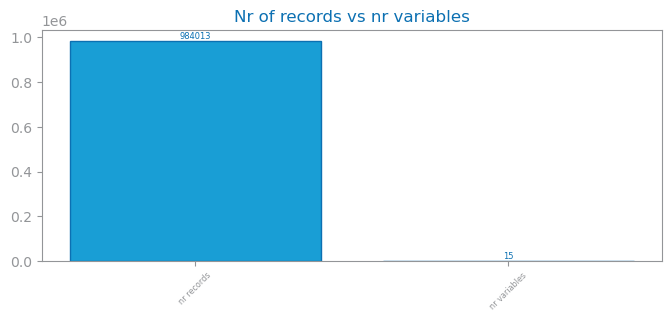

In [130]:
from matplotlib.pyplot import figure, savefig, show


figure(figsize=(8, 3)) #(largura,altura) 

values: dict[str, int] = {"nr records": df_cart.shape[0], "nr variables": df_cart.shape[1]}

#df_shape[0] - retorna o numero de linhas
#df_shape[1] - retorna o numero de colunas


plot_bar_chart(
    list(values.keys())\
    ,list(values.values())\
    ,title="Nr of records vs nr variables"
)
#savefig(f"images/{file_tag}_records_variables.png")
show()

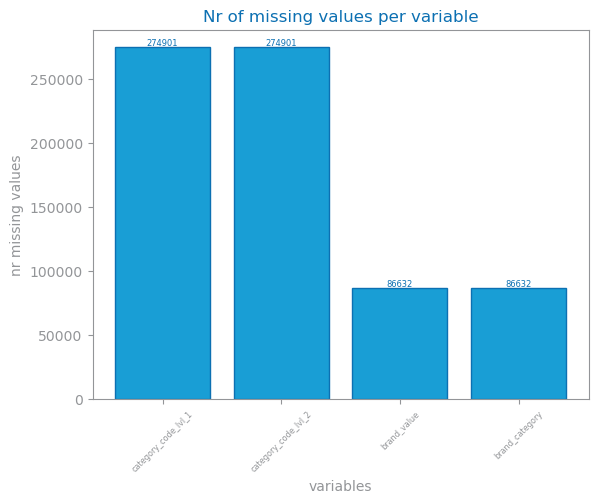

In [131]:

mv: dict[str, int] = {}
for var in df_cart.columns:
    nr: int = df_cart[var].isna().sum()

    if nr > 0:
        mv[var] = nr

figure()
plot_bar_chart(
    list(mv.keys()),
    list(mv.values()),
    title="Nr of missing values per variable",
    xlabel="variables",
    ylabel="nr missing values",
)
#savefig(f"images/{file_tag}_mv.png")
show()

dslabs_functions lodaded


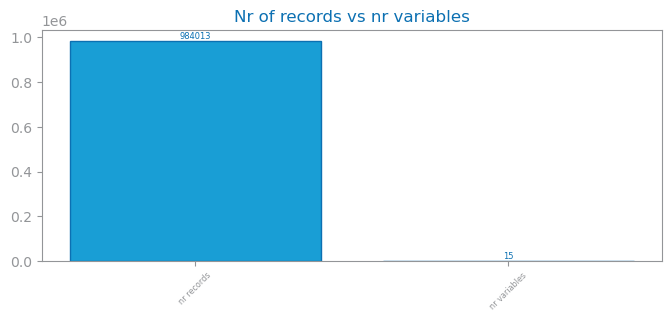

In [132]:
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import plot_bar_chart

figure(figsize=(8, 3))
values: dict[str, int] = {"nr records": df_cart.shape[0], "nr variables": df_cart.shape[1]}
plot_bar_chart(
    list(values.keys()), list(values.values()), title="Nr of records vs nr variables"
)
#savefig(f"images/{file_tag}_records_variables.png")
show()

is_purchase
0    836473
1    147540
Name: count, dtype: int64


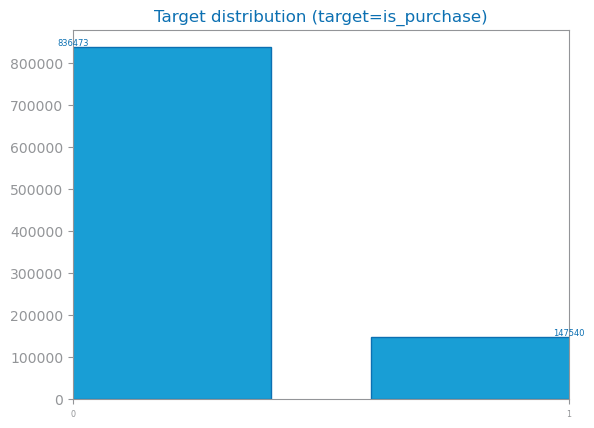

In [133]:
from matplotlib.pyplot import savefig, show
target = "is_purchase"

values: Series = df_cart[target].value_counts()
print(values)

Figure(figsize=(4, 2))
plot_bar_chart(
    values.index.to_list(),
    values.to_list(),
    title=f"Target distribution (target={target})",
)
#savefig(f"images/{file_tag}_class_distribution.png")
show()

# Save final df from pre_processing phase into a csv file
- We will use this dataset for the next phase - data profiling

In [154]:
# Definir o caminho para salvar o arquivo CSV
filepath = r'dataset/df_ecom_pre_proc_vcleaned.csv'

# Salvar o DataFrame em CSV
df_cart.to_csv(filepath, index=False)

In [155]:
# Verificar se 'event_time' está presente e é do tipo datetime
if 'event_time' in df_cart.columns and pd.api.types.is_datetime64_any_dtype(df_cart['event_time']):
    # Conta o número de dias únicos
    num_unique_days = df_cart['event_time'].nunique()
    print(f"Número de dias únicos: {num_unique_days}")
else:
    print("A coluna 'event_time' não existe ou não é do tipo datetime.")

# Contar valores distintos em todas as colunas
distinct_values = df_cart.nunique()
print("Número de valores distintos por coluna:")
print(distinct_values)

A coluna 'event_time' não existe ou não é do tipo datetime.
Número de valores distintos por coluna:
category_code_lvl_1       13
category_code_lvl_2       60
price                  24884
is_purchase                2
activity_in_session      120
week_of_month              5
is_weekend                 2
day_of_week                7
day                       30
hour                      24
min                       60
time_of_day                4
brand_value             1661
brand_category          3012
product_category       60657
dtype: int64
